# Loading Modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import imageio
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from what_where.main import init, MNIST
from what_where.what import WhatShift, WhatBackground, WhatNet
from stn import STN
from utils import view_data_rand

# Loading the Data

- Loading the data with the parameters given in the .json file for the What/Where model

In [2]:
args = init(filename='what_where/2020-07-01')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'what_offset_std': 15,
 'what_offset_max': 25,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'do_mask': True,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': False,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2020-07-01',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}

# Exploring the MNIST with the what noise parameters

- 28x28 pixel with shift and noise

In [52]:
args.contrast = 0.7

In [53]:
transform=transforms.Compose([
                               WhatShift(args),
                               WhatBackground(contrast = args.contrast,
                                              noise=args.noise, 
                                              sf_0=args.sf_0, 
                                              B_sf=args.B_sf),
                               transforms.ToTensor(),
                               #transforms.Normalize((args.mean,), (args.std,))
                           #transforms.Normalize((0.4914,))
                           ])

dataset_train = MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform,
                        )

train_loader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        )

test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

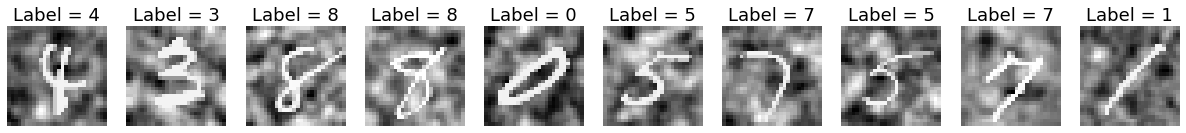

In [54]:
data = view_data_rand(train_loader)
#data.savefig('../figures/noisy_no_shift_28x28_data.png')

# Spatial Transformer Network

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = torch.load(PATH).to(device)
model = STN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()#model = STN().to(device)
loss_vals=  []
acc_vals = []

In [41]:
def train(epoch, loader):

    epoch_loss= []
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, dtype=torch.float), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        batch_loss = loss.item()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, args.epochs, batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), batch_loss))
        epoch_loss.append(batch_loss)
    #loss_vals.append(sum(epoch_loss)/len(epoch_loss))


def test(loader):

    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in loader:
            data, target = data.to(device,
                                   dtype=torch.float), target.to(device)
            output = model(data)
            test_loss += loss_func(output, target).item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        
        acc = correct / len(test_loader.dataset)
        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(test_loader.dataset),
                     100. * acc))
        return acc
        #acc_vals.append(acc)

In [21]:
for ofst in range(15 + 1):

    args.contrast = None #setting contrast as variable
    args.what_offset_std = ofst
    print("Training on offset_std = %s" % (args.what_offset_std))
    transform = transforms.Compose([
        WhatShift(args),
        WhatBackground(contrast=args.contrast,
                       noise=args.noise,
                       sf_0=args.sf_0,
                       B_sf=args.B_sf),
        transforms.ToTensor(),
        #transforms.Normalize((args.mean,), (args.std,))
    ])

    train_loader = torch.utils.data.DataLoader(MNIST(
        '../data',
        train=True,
        download=True,
        transform=transform,
    ),
                                               batch_size=args.minibatch_size,
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(MNIST(
        '../data',
        train=False,
        download=True,
        transform=transform,
    ),
                                              batch_size=args.minibatch_size,
                                              shuffle=True)

    args.epochs = 10
    for epoch in range(1, args.epochs + 1):
        train(epoch, train_loader) 
        test(test_loader)

Training on offset_std = 0
Train Epoch: 1/10 [0/60000 (0%)]	Loss: 2.297604
Train Epoch: 1/10 [10000/60000 (17%)]	Loss: 2.305750
Train Epoch: 1/10 [20000/60000 (33%)]	Loss: 2.301870
Train Epoch: 1/10 [30000/60000 (50%)]	Loss: 2.299007
Train Epoch: 1/10 [40000/60000 (67%)]	Loss: 2.309124
Train Epoch: 1/10 [50000/60000 (83%)]	Loss: 2.298584

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

Train Epoch: 2/10 [0/60000 (0%)]	Loss: 2.300381
Train Epoch: 2/10 [10000/60000 (17%)]	Loss: 2.299384
Train Epoch: 2/10 [20000/60000 (33%)]	Loss: 2.284578
Train Epoch: 2/10 [30000/60000 (50%)]	Loss: 2.288436
Train Epoch: 2/10 [40000/60000 (67%)]	Loss: 2.299298
Train Epoch: 2/10 [50000/60000 (83%)]	Loss: 2.297307

Test set: Average loss: 0.0229, Accuracy: 1531/10000 (15%)

Train Epoch: 3/10 [0/60000 (0%)]	Loss: 2.296025
Train Epoch: 3/10 [10000/60000 (17%)]	Loss: 2.279815
Train Epoch: 3/10 [20000/60000 (33%)]	Loss: 2.281907
Train Epoch: 3/10 [30000/60000 (50%)]	Loss: 2.279850
Train Epoch: 3/10 

Train Epoch: 2/10 [50000/60000 (83%)]	Loss: 0.534727

Test set: Average loss: 0.0045, Accuracy: 8605/10000 (86%)

Train Epoch: 3/10 [0/60000 (0%)]	Loss: 0.489443
Train Epoch: 3/10 [10000/60000 (17%)]	Loss: 0.734635
Train Epoch: 3/10 [20000/60000 (33%)]	Loss: 0.448707
Train Epoch: 3/10 [30000/60000 (50%)]	Loss: 0.507668
Train Epoch: 3/10 [40000/60000 (67%)]	Loss: 0.405509
Train Epoch: 3/10 [50000/60000 (83%)]	Loss: 0.416903

Test set: Average loss: 0.0050, Accuracy: 8424/10000 (84%)

Train Epoch: 4/10 [0/60000 (0%)]	Loss: 0.538859
Train Epoch: 4/10 [10000/60000 (17%)]	Loss: 0.660923
Train Epoch: 4/10 [20000/60000 (33%)]	Loss: 0.507437
Train Epoch: 4/10 [30000/60000 (50%)]	Loss: 0.600264
Train Epoch: 4/10 [40000/60000 (67%)]	Loss: 0.533684
Train Epoch: 4/10 [50000/60000 (83%)]	Loss: 0.655505

Test set: Average loss: 0.0044, Accuracy: 8610/10000 (86%)

Train Epoch: 5/10 [0/60000 (0%)]	Loss: 0.293718
Train Epoch: 5/10 [10000/60000 (17%)]	Loss: 0.486622
Train Epoch: 5/10 [20000/60000 (33%)]

Train Epoch: 4/10 [40000/60000 (67%)]	Loss: 0.396948
Train Epoch: 4/10 [50000/60000 (83%)]	Loss: 0.560789

Test set: Average loss: 0.0049, Accuracy: 8529/10000 (85%)

Train Epoch: 5/10 [0/60000 (0%)]	Loss: 0.564054
Train Epoch: 5/10 [10000/60000 (17%)]	Loss: 0.387098
Train Epoch: 5/10 [20000/60000 (33%)]	Loss: 0.495279
Train Epoch: 5/10 [30000/60000 (50%)]	Loss: 0.573697
Train Epoch: 5/10 [40000/60000 (67%)]	Loss: 0.498756
Train Epoch: 5/10 [50000/60000 (83%)]	Loss: 0.857288

Test set: Average loss: 0.0049, Accuracy: 8491/10000 (85%)

Train Epoch: 6/10 [0/60000 (0%)]	Loss: 0.526349
Train Epoch: 6/10 [10000/60000 (17%)]	Loss: 0.608882
Train Epoch: 6/10 [20000/60000 (33%)]	Loss: 0.515503
Train Epoch: 6/10 [30000/60000 (50%)]	Loss: 0.596880
Train Epoch: 6/10 [40000/60000 (67%)]	Loss: 0.586884
Train Epoch: 6/10 [50000/60000 (83%)]	Loss: 0.600002

Test set: Average loss: 0.0051, Accuracy: 8411/10000 (84%)

Train Epoch: 7/10 [0/60000 (0%)]	Loss: 0.572424
Train Epoch: 7/10 [10000/60000 (17%)]

Train Epoch: 6/10 [30000/60000 (50%)]	Loss: 0.572317
Train Epoch: 6/10 [40000/60000 (67%)]	Loss: 0.801276
Train Epoch: 6/10 [50000/60000 (83%)]	Loss: 0.686902

Test set: Average loss: 0.0064, Accuracy: 7942/10000 (79%)

Train Epoch: 7/10 [0/60000 (0%)]	Loss: 0.487390
Train Epoch: 7/10 [10000/60000 (17%)]	Loss: 0.560206
Train Epoch: 7/10 [20000/60000 (33%)]	Loss: 0.524178
Train Epoch: 7/10 [30000/60000 (50%)]	Loss: 0.561387
Train Epoch: 7/10 [40000/60000 (67%)]	Loss: 0.736827
Train Epoch: 7/10 [50000/60000 (83%)]	Loss: 0.689189

Test set: Average loss: 0.0063, Accuracy: 7987/10000 (80%)

Train Epoch: 8/10 [0/60000 (0%)]	Loss: 0.573162
Train Epoch: 8/10 [10000/60000 (17%)]	Loss: 0.658451
Train Epoch: 8/10 [20000/60000 (33%)]	Loss: 0.641256
Train Epoch: 8/10 [30000/60000 (50%)]	Loss: 0.787618
Train Epoch: 8/10 [40000/60000 (67%)]	Loss: 0.660255
Train Epoch: 8/10 [50000/60000 (83%)]	Loss: 0.595712

Test set: Average loss: 0.0077, Accuracy: 7480/10000 (75%)

Train Epoch: 9/10 [0/60000 (0%)]

Train Epoch: 8/10 [20000/60000 (33%)]	Loss: 0.772493
Train Epoch: 8/10 [30000/60000 (50%)]	Loss: 0.797896
Train Epoch: 8/10 [40000/60000 (67%)]	Loss: 0.746661
Train Epoch: 8/10 [50000/60000 (83%)]	Loss: 0.795018

Test set: Average loss: 0.0083, Accuracy: 7154/10000 (72%)

Train Epoch: 9/10 [0/60000 (0%)]	Loss: 0.756146
Train Epoch: 9/10 [10000/60000 (17%)]	Loss: 0.875311
Train Epoch: 9/10 [20000/60000 (33%)]	Loss: 0.953853
Train Epoch: 9/10 [30000/60000 (50%)]	Loss: 0.855448
Train Epoch: 9/10 [40000/60000 (67%)]	Loss: 0.749228
Train Epoch: 9/10 [50000/60000 (83%)]	Loss: 0.803925

Test set: Average loss: 0.0082, Accuracy: 7194/10000 (72%)

Train Epoch: 10/10 [0/60000 (0%)]	Loss: 0.565261
Train Epoch: 10/10 [10000/60000 (17%)]	Loss: 0.947083
Train Epoch: 10/10 [20000/60000 (33%)]	Loss: 0.734782
Train Epoch: 10/10 [30000/60000 (50%)]	Loss: 0.799180
Train Epoch: 10/10 [40000/60000 (67%)]	Loss: 0.812765
Train Epoch: 10/10 [50000/60000 (83%)]	Loss: 0.891314

Test set: Average loss: 0.0082, A

Train Epoch: 10/10 [10000/60000 (17%)]	Loss: 0.868221
Train Epoch: 10/10 [20000/60000 (33%)]	Loss: 1.266160
Train Epoch: 10/10 [30000/60000 (50%)]	Loss: 0.943894
Train Epoch: 10/10 [40000/60000 (67%)]	Loss: 0.961343
Train Epoch: 10/10 [50000/60000 (83%)]	Loss: 1.160404

Test set: Average loss: 0.0112, Accuracy: 6069/10000 (61%)

Training on offset_std = 11
Train Epoch: 1/10 [0/60000 (0%)]	Loss: 1.190177
Train Epoch: 1/10 [10000/60000 (17%)]	Loss: 1.229479
Train Epoch: 1/10 [20000/60000 (33%)]	Loss: 1.322639
Train Epoch: 1/10 [30000/60000 (50%)]	Loss: 1.227082
Train Epoch: 1/10 [40000/60000 (67%)]	Loss: 1.467682
Train Epoch: 1/10 [50000/60000 (83%)]	Loss: 0.966360

Test set: Average loss: 0.0121, Accuracy: 5751/10000 (58%)

Train Epoch: 2/10 [0/60000 (0%)]	Loss: 1.269260
Train Epoch: 2/10 [10000/60000 (17%)]	Loss: 1.110947
Train Epoch: 2/10 [20000/60000 (33%)]	Loss: 1.121860
Train Epoch: 2/10 [30000/60000 (50%)]	Loss: 1.239181
Train Epoch: 2/10 [40000/60000 (67%)]	Loss: 1.009327
Train E


Test set: Average loss: 0.0138, Accuracy: 5000/10000 (50%)

Train Epoch: 2/10 [0/60000 (0%)]	Loss: 1.326374
Train Epoch: 2/10 [10000/60000 (17%)]	Loss: 1.486702
Train Epoch: 2/10 [20000/60000 (33%)]	Loss: 1.344674
Train Epoch: 2/10 [30000/60000 (50%)]	Loss: 1.513554
Train Epoch: 2/10 [40000/60000 (67%)]	Loss: 1.481501
Train Epoch: 2/10 [50000/60000 (83%)]	Loss: 1.426336

Test set: Average loss: 0.0140, Accuracy: 4920/10000 (49%)

Train Epoch: 3/10 [0/60000 (0%)]	Loss: 1.327049
Train Epoch: 3/10 [10000/60000 (17%)]	Loss: 1.282701
Train Epoch: 3/10 [20000/60000 (33%)]	Loss: 1.230832
Train Epoch: 3/10 [30000/60000 (50%)]	Loss: 1.433249
Train Epoch: 3/10 [40000/60000 (67%)]	Loss: 1.547796
Train Epoch: 3/10 [50000/60000 (83%)]	Loss: 1.475703

Test set: Average loss: 0.0137, Accuracy: 5064/10000 (51%)

Train Epoch: 4/10 [0/60000 (0%)]	Loss: 1.395684
Train Epoch: 4/10 [10000/60000 (17%)]	Loss: 1.513240
Train Epoch: 4/10 [20000/60000 (33%)]	Loss: 1.321645
Train Epoch: 4/10 [30000/60000 (50%)]

Train Epoch: 3/10 [50000/60000 (83%)]	Loss: 1.670265

Test set: Average loss: 0.0150, Accuracy: 4524/10000 (45%)

Train Epoch: 4/10 [0/60000 (0%)]	Loss: 1.563520
Train Epoch: 4/10 [10000/60000 (17%)]	Loss: 1.590750
Train Epoch: 4/10 [20000/60000 (33%)]	Loss: 1.738926
Train Epoch: 4/10 [30000/60000 (50%)]	Loss: 1.642591
Train Epoch: 4/10 [40000/60000 (67%)]	Loss: 1.617350
Train Epoch: 4/10 [50000/60000 (83%)]	Loss: 1.452112

Test set: Average loss: 0.0151, Accuracy: 4448/10000 (44%)

Train Epoch: 5/10 [0/60000 (0%)]	Loss: 1.344465
Train Epoch: 5/10 [10000/60000 (17%)]	Loss: 1.402256
Train Epoch: 5/10 [20000/60000 (33%)]	Loss: 1.777185
Train Epoch: 5/10 [30000/60000 (50%)]	Loss: 1.682967
Train Epoch: 5/10 [40000/60000 (67%)]	Loss: 1.455932
Train Epoch: 5/10 [50000/60000 (83%)]	Loss: 1.407300

Test set: Average loss: 0.0151, Accuracy: 4433/10000 (44%)

Train Epoch: 6/10 [0/60000 (0%)]	Loss: 1.564842
Train Epoch: 6/10 [10000/60000 (17%)]	Loss: 1.337565
Train Epoch: 6/10 [20000/60000 (33%)]

In [61]:
args.what_offset_std = 7
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    return inp

thetas = []
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0][:24, :, :, :].to(device) # taking only a batch of 64 for a better plot

        input_tensor = data.cpu()
        
        output_tensor, theta = model.transformer_module.stn(data)
        thetas.append(theta)
        
        transformed_input_tensor = output_tensor.cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2, dpi=300)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')
        axarr[0].set_xticks([])
        axarr[0].set_yticks([])

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')
        axarr[1].set_xticks([])
        axarr[1].set_yticks([])
        #f.savefig('../figures/transforms_28x28.png')

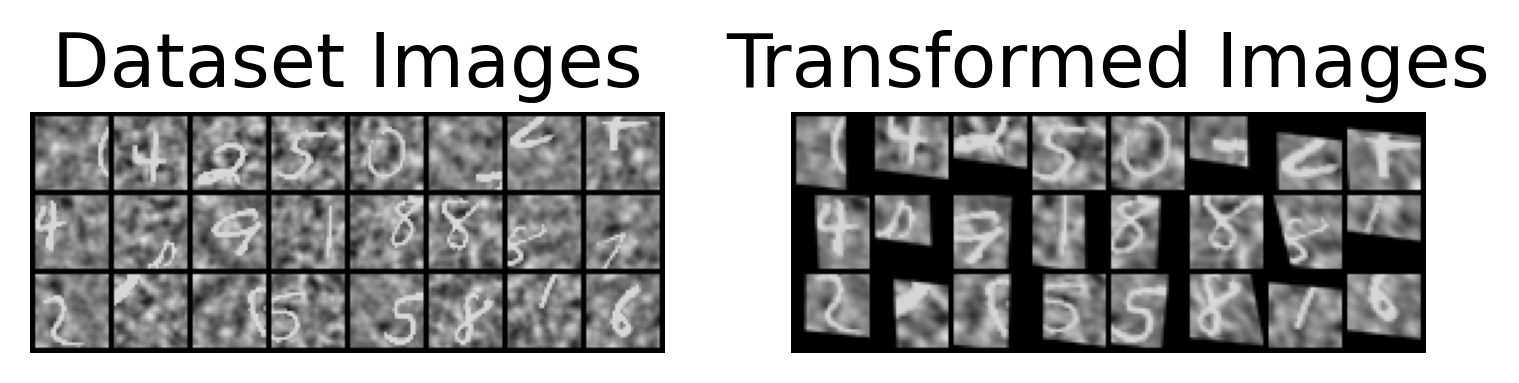

In [62]:
visualize_stn()

In [26]:
thetas

[tensor([[[ 7.3825e-01,  2.5302e-03,  6.9305e-01],
          [-1.1259e-01,  7.9883e-01,  4.5036e-01]],
 
         [[ 7.7166e-01,  6.5801e-02,  4.2905e-01],
          [-8.4913e-02,  8.4999e-01, -2.4777e-01]],
 
         [[ 7.3980e-01, -4.1097e-03,  6.3245e-01],
          [-9.7824e-02,  8.2318e-01,  2.0250e-01]],
 
         [[ 7.1725e-01,  4.9246e-03, -4.9387e-01],
          [-1.0859e-01,  7.8714e-01,  6.1684e-01]],
 
         [[ 7.6382e-01, -1.2701e-02, -1.8077e-01],
          [-8.8766e-02,  7.9970e-01, -2.7724e-01]],
 
         [[ 7.3256e-01, -2.0894e-02,  7.0562e-01],
          [-9.7823e-02,  7.6328e-01,  6.4689e-01]],
 
         [[ 8.5121e-01, -6.8645e-02,  8.8534e-02],
          [-1.2222e-01,  7.0266e-01,  1.2085e+00]],
 
         [[ 7.2557e-01, -2.6355e-03,  6.5801e-01],
          [-9.2559e-02,  8.2615e-01,  1.9359e-01]],
 
         [[ 7.5463e-01,  2.7877e-02,  4.6909e-01],
          [-6.6328e-02,  8.4657e-01, -2.0123e-01]],
 
         [[ 7.5288e-01, -4.3826e-02, -4.7452e-01],
    

# Saving the model

In [51]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = "../models/stn_28x28.pt"
#torch.save(model, PATH)

# General accuracy

In [27]:
args.what_offset_std = 15

In [28]:
test(test_loader)


Test set: Average loss: 0.0158, Accuracy: 4261/10000 (43%)



# Central accuracy

In [29]:
args.what_offset_std = 0
test_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)

In [30]:
test(test_loader)


Test set: Average loss: 0.0040, Accuracy: 8764/10000 (88%)



# Loss and accuracy over epochs

In [37]:
acc_vals = [
    0.1135, 0.1531, 0.2793, 0.4494, 0.5743, 0.6432, 0.6905, 0.7479, 0.7751,
    0.8213, 0.8111, 0.8334, 0.835, 0.8527, 0.8728, 0.8705, 0.8863, 0.8788,
    0.888, 0.8901, 0.8429, 0.8605, 0.8424, 0.861, 0.8792, 0.8699, 0.8754,
    0.8797, 0.8805, 0.8776, 0.8211, 0.8531, 0.845, 0.8496, 0.8575, 0.864,
    0.8738, 0.8654, 0.8595, 0.8841, 0.8328, 0.7993, 0.8196, 0.8529, 0.8491,
    0.8411, 0.8222, 0.8507, 0.8537, 0.8664, 0.7951, 0.8143, 0.8045, 0.8165,
    0.8262, 0.827, 0.7707, 0.8069, 0.8136, 0.731, 0.771, 0.7865, 0.7781,
    0.7749, 0.7882, 0.7942, 0.7987, 0.748, 0.7965, 0.7793, 0.7381, 0.7521,
    0.7483, 0.7505, 0.7512, 0.7653, 0.7675, 0.7125, 0.7451, 0.7661, 0.6793,
    0.7023, 0.6894, 0.7034, 0.6551, 0.7063, 0.7059, 0.7154, 0.7194, 0.7207,
    0.6715, 0.6485, 0.598, 0.6624, 0.6666, 0.6751, 0.6673, 0.6686, 0.6646,
    0.6796, 0.6101, 0.637, 0.6352, 0.6016, 0.6244, 0.6333, 0.6338, 0.6392,
    0.6255, 0.6069, 0.5751, 0.5824, 0.5584, 0.5905, 0.5844, 0.5738, 0.6022,
    0.5863, 0.6055, 0.5839, 0.5394, 0.5478, 0.5481, 0.5436, 0.5274, 0.5481,
    0.5432, 0.4433, 0.5455, 0.4968, 0.5, 0.492, 0.5064, 0.5006, 0.4941, 0.5006,
    0.5117, 0.5135, 0.5096, 0.5089, 0.4344, 0.4596, 0.4545, 0.4651, 0.4855,
    0.4766, 0.286, 0.4687, 0.48, 0.4776, 0.4352, 0.4442, 0.4524, 0.4448,
    0.4433, 0.3653, 0.3782, 0.3982, 0.4478, 0.4261, 0.4261
]

loss_vals = [
    2.3003400238355, 2.2948713072141014, 2.2789375154177347,
    2.1234522420167923, 1.4902742846806845, 1.2141778894265494,
    1.0517753930886586, 0.9035123793284098, 0.7625668423871199,
    0.6471165127058824, 0.734802680661281, 0.6447404270370801,
    0.5762985884149869, 0.5228287870436907, 0.48168405403693515,
    0.4508862754205863, 0.4174119325727224, 0.3959187462925911,
    0.37153232979277767, 0.3555116318911314, 0.6266991055508455,
    0.5501478950182597, 0.5055254100759824, 0.47916115817924343,
    0.4596699063976606, 0.4375200697531303, 0.41763070908685523,
    0.4005404681960742, 0.3819637040545543, 0.37377721664806207,
    0.5855400029321511, 0.5350314255555471, 0.5135606443385283,
    0.4888812640060981, 0.4666789302974939, 0.45364895204703015,
    0.43501181570192177, 0.42602522927025954, 0.4174036340415478,
    0.4007523576915264, 0.6353963717321555, 0.591818229953448,
    0.5693826986352603, 0.5414973450203736, 0.5273774801691373,
    0.5160761903723081, 0.5061365232119958, 0.4861845633884271,
    0.48361501142382624, 0.49516991317272185, 0.6953508698443571,
    0.6757885668675104, 0.6510274369517962, 0.635412082374096,
    0.6161149471501509, 0.5976237116257349, 0.5960332543154557,
    0.5838736296693484, 0.5740799770255883, 0.5703287600477537,
    0.7791209753851096, 0.7674181696772575, 0.7258968734741211,
    0.7155117625494798, 0.7145793517927329, 0.6892962072789669,
    0.6786048220098019, 0.6690501570701599, 0.6630387474596501,
    0.6488267628351847, 0.8374488960703214, 0.830497280061245,
    0.8041097936034203, 0.803327267964681, 0.784691068182389,
    0.7781114167471727, 0.7839146210749944, 0.7531611994902293,
    0.7488363579909006, 0.7404106575747331, 0.9382636552055676,
    0.9287786967555682, 0.9199120761950811, 0.9447034159302712,
    0.897099851667881, 0.8828340834379196, 0.8871834863225619,
    0.8615084284543991, 0.8639434578518073, 0.8653812111417453,
    1.0270041284958522, 1.057638447980086, 1.019283432662487,
    1.0771382758021355, 1.0175455542405447, 0.9965981355309487,
    0.9776810429493586, 0.9755496353904406, 0.9667820628484091,
    0.9694702354073524, 1.128412988781929, 1.1025813919305802,
    1.099151926736037, 1.1366113726298015, 1.1000244441628455,
    1.0793736574053765, 1.0868724474310876, 1.0725335458914438,
    1.0636427906155586, 1.062759667634964, 1.2350070070226986,
    1.1977800627549489, 1.1926323955257734, 1.1685400212804475,
    1.1717453867197036, 1.1669086038072904, 1.1632695394754409,
    1.1448450817664464, 1.1836996929844221, 1.1635229779283205,
    1.3116387097040811, 1.3335141172011693, 1.2879906109968822,
    1.3066987625757853, 1.3113771768411, 1.3070180160800615, 1.363539374868075,
    1.3268556582927704, 1.324250018497308, 1.303812210758527,
    1.4150458667675654, 1.398668251534303, 1.3846110632022222,
    1.3929780892531076, 1.3919461544354756, 1.39854168176651,
    1.3867158142725626, 1.3858029691378275, 1.3802789417902628,
    1.377170382340749, 1.4943175754944484, 1.4944344369570415,
    1.4764676511287689, 1.5163555810848872, 1.4845379996299743,
    1.4703513145446778, 1.4825877116123836, 1.5080930956204732,
    1.4597740530967713, 1.4557161112626393, 1.5484893395503363,
    1.5608873218297958, 1.5407279201348623, 1.534367593129476,
    1.5321496125062306, 1.7009653407335281, 1.6647799887259802,
    1.6668956969181696, 1.6375817024707795, 1.5411693342526753
]

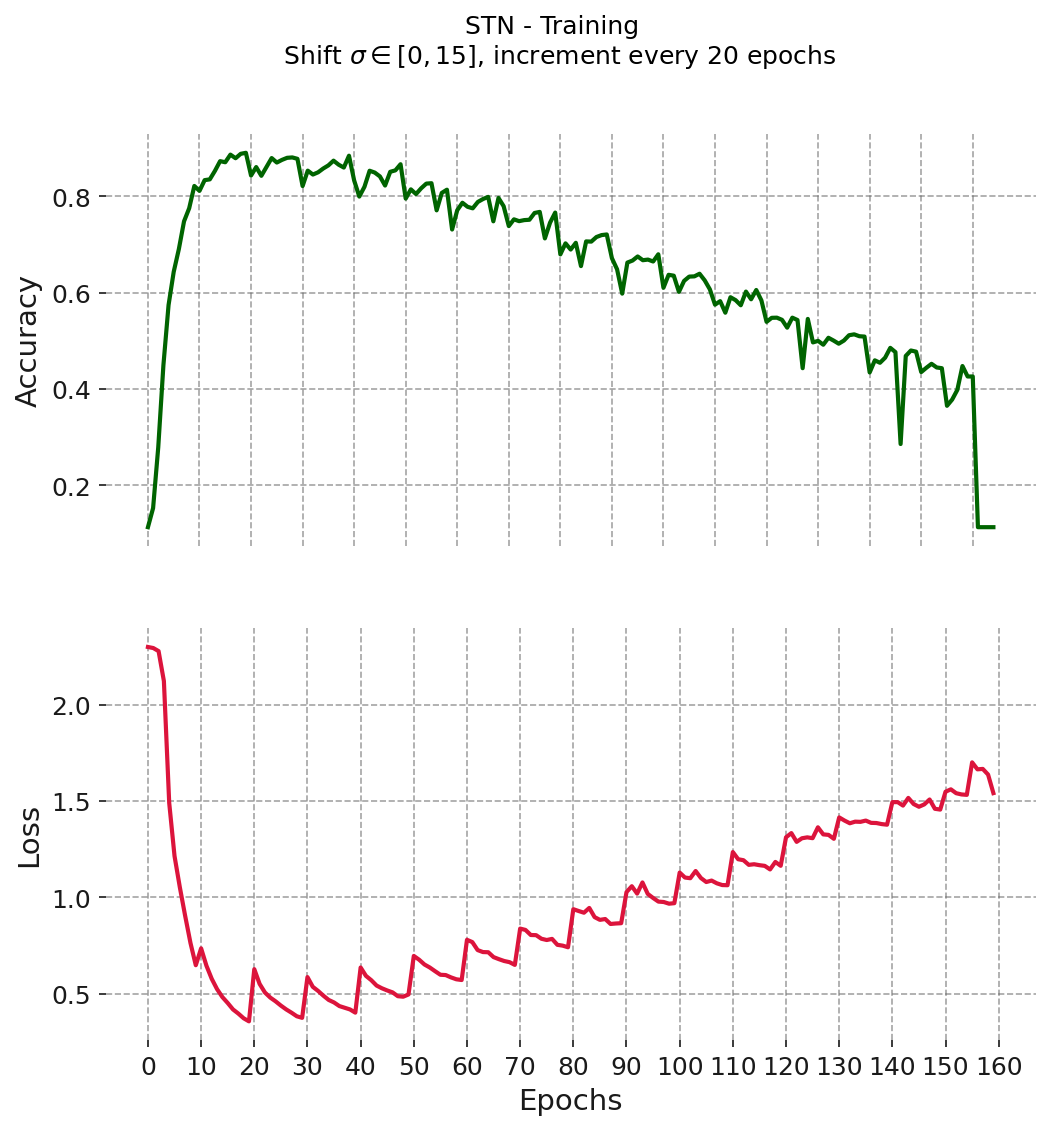

In [50]:
plt.style.use("gadfly")
fig, ax = plt.subplots(2, 1, dpi=150, figsize=(8, 8))
ax[0].plot(acc_vals, 'darkgreen')
ax[1].plot(loss_vals, 'crimson')

for i in range(2):
    ax[i].set_xticks([e for e in range(0, 170, 10)])

ax[0].tick_params(axis='x',  which='both',  bottom=False,
                  top=False, labelbottom=False)
    
ax[0].set_ylabel("Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")


#for i in range(2):
#    ax[i].grid(axis='x', linestyle='--')
fig.suptitle("STN - Training \n Shift $\sigma \in [0,15]$, increment every 20 epochs")
#fig.savefig('../figures/loss_acc_training_stn_28x28.png')

# Accuracy map

## Generating and saving the accuracy map

In [42]:
accuracy_map = np.zeros((55, 55))

In [43]:
for i in range(-27,28):
    for j in range(-27,28):
        transform=transforms.Compose([
                               WhatShift(args, i_offset=i, j_offset=j),
                               WhatBackground(contrast = args.contrast,
                                              noise=args.noise, 
                                              sf_0=args.sf_0, 
                                              B_sf=args.B_sf),
                               transforms.ToTensor(),
                               #transforms.Normalize((args.mean,), (args.std,))
                           ])
        test_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)
        accuracy = test(test_loader)
        accuracy_map[i + 27, j + 27] = accuracy 
        print(i, j, accuracy) 


Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-27 -27 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-27 -26 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-27 -25 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-27 -24 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-27 -23 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-27 -22 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-27 -21 0.1135

Test set: Average loss: 0.0231, Accuracy: 1137/10000 (11%)

-27 -20 0.1137

Test set: Average loss: 0.0231, Accuracy: 1138/10000 (11%)

-27 -19 0.1138

Test set: Average loss: 0.0231, Accuracy: 1137/10000 (11%)

-27 -18 0.1137

Test set: Average loss: 0.0231, Accuracy: 1142/10000 (11%)

-27 -17 0.1142

Test set: Average loss: 0.0231, Accuracy: 1138/10000 (11%)

-27 -16 0.1138

Test set: Average loss: 0.0231, Accuracy: 1142/10000 (11%)

-27 -15 0.1142

Test set: A


Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-25 -27 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-25 -26 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-25 -25 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-25 -24 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-25 -23 0.1135

Test set: Average loss: 0.0231, Accuracy: 1136/10000 (11%)

-25 -22 0.1136

Test set: Average loss: 0.0231, Accuracy: 1139/10000 (11%)

-25 -21 0.1139

Test set: Average loss: 0.0231, Accuracy: 1142/10000 (11%)

-25 -20 0.1142

Test set: Average loss: 0.0231, Accuracy: 1143/10000 (11%)

-25 -19 0.1143

Test set: Average loss: 0.0231, Accuracy: 1151/10000 (12%)

-25 -18 0.1151

Test set: Average loss: 0.0231, Accuracy: 1180/10000 (12%)

-25 -17 0.118

Test set: Average loss: 0.0231, Accuracy: 1198/10000 (12%)

-25 -16 0.1198

Test set: Average loss: 0.0231, Accuracy: 1225/10000 (12%)

-25 -15 0.1225

Test set: Av


Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-23 -27 0.1135

Test set: Average loss: 0.0231, Accuracy: 1136/10000 (11%)

-23 -26 0.1136

Test set: Average loss: 0.0231, Accuracy: 1136/10000 (11%)

-23 -25 0.1136

Test set: Average loss: 0.0231, Accuracy: 1136/10000 (11%)

-23 -24 0.1136

Test set: Average loss: 0.0231, Accuracy: 1141/10000 (11%)

-23 -23 0.1141

Test set: Average loss: 0.0231, Accuracy: 1141/10000 (11%)

-23 -22 0.1141

Test set: Average loss: 0.0231, Accuracy: 1155/10000 (12%)

-23 -21 0.1155

Test set: Average loss: 0.0231, Accuracy: 1177/10000 (12%)

-23 -20 0.1177

Test set: Average loss: 0.0231, Accuracy: 1181/10000 (12%)

-23 -19 0.1181

Test set: Average loss: 0.0232, Accuracy: 1200/10000 (12%)

-23 -18 0.12

Test set: Average loss: 0.0232, Accuracy: 1211/10000 (12%)

-23 -17 0.1211

Test set: Average loss: 0.0232, Accuracy: 1210/10000 (12%)

-23 -16 0.121

Test set: Average loss: 0.0233, Accuracy: 1185/10000 (12%)

-23 -15 0.1185

Test set: Aver


Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-21 -27 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-21 -26 0.1135

Test set: Average loss: 0.0231, Accuracy: 1140/10000 (11%)

-21 -25 0.114

Test set: Average loss: 0.0231, Accuracy: 1144/10000 (11%)

-21 -24 0.1144

Test set: Average loss: 0.0230, Accuracy: 1146/10000 (11%)

-21 -23 0.1146

Test set: Average loss: 0.0231, Accuracy: 1175/10000 (12%)

-21 -22 0.1175

Test set: Average loss: 0.0231, Accuracy: 1184/10000 (12%)

-21 -21 0.1184

Test set: Average loss: 0.0231, Accuracy: 1222/10000 (12%)

-21 -20 0.1222

Test set: Average loss: 0.0232, Accuracy: 1282/10000 (13%)

-21 -19 0.1282

Test set: Average loss: 0.0233, Accuracy: 1281/10000 (13%)

-21 -18 0.1281

Test set: Average loss: 0.0233, Accuracy: 1309/10000 (13%)

-21 -17 0.1309

Test set: Average loss: 0.0234, Accuracy: 1299/10000 (13%)

-21 -16 0.1299

Test set: Average loss: 0.0233, Accuracy: 1263/10000 (13%)

-21 -15 0.1263

Test set: Av


Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-19 -27 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-19 -26 0.1135

Test set: Average loss: 0.0230, Accuracy: 1151/10000 (12%)

-19 -25 0.1151

Test set: Average loss: 0.0231, Accuracy: 1150/10000 (12%)

-19 -24 0.115

Test set: Average loss: 0.0231, Accuracy: 1170/10000 (12%)

-19 -23 0.117

Test set: Average loss: 0.0231, Accuracy: 1199/10000 (12%)

-19 -22 0.1199

Test set: Average loss: 0.0231, Accuracy: 1232/10000 (12%)

-19 -21 0.1232

Test set: Average loss: 0.0232, Accuracy: 1259/10000 (13%)

-19 -20 0.1259

Test set: Average loss: 0.0232, Accuracy: 1308/10000 (13%)

-19 -19 0.1308

Test set: Average loss: 0.0233, Accuracy: 1347/10000 (13%)

-19 -18 0.1347

Test set: Average loss: 0.0233, Accuracy: 1366/10000 (14%)

-19 -17 0.1366

Test set: Average loss: 0.0234, Accuracy: 1311/10000 (13%)

-19 -16 0.1311

Test set: Average loss: 0.0234, Accuracy: 1308/10000 (13%)

-19 -15 0.1308

Test set: Ave


Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-17 -27 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-17 -26 0.1135

Test set: Average loss: 0.0231, Accuracy: 1143/10000 (11%)

-17 -25 0.1143

Test set: Average loss: 0.0231, Accuracy: 1154/10000 (12%)

-17 -24 0.1154

Test set: Average loss: 0.0231, Accuracy: 1190/10000 (12%)

-17 -23 0.119

Test set: Average loss: 0.0231, Accuracy: 1228/10000 (12%)

-17 -22 0.1228

Test set: Average loss: 0.0232, Accuracy: 1264/10000 (13%)

-17 -21 0.1264

Test set: Average loss: 0.0232, Accuracy: 1304/10000 (13%)

-17 -20 0.1304

Test set: Average loss: 0.0232, Accuracy: 1370/10000 (14%)

-17 -19 0.137

Test set: Average loss: 0.0233, Accuracy: 1415/10000 (14%)

-17 -18 0.1415

Test set: Average loss: 0.0233, Accuracy: 1461/10000 (15%)

-17 -17 0.1461

Test set: Average loss: 0.0233, Accuracy: 1409/10000 (14%)

-17 -16 0.1409

Test set: Average loss: 0.0233, Accuracy: 1277/10000 (13%)

-17 -15 0.1277

Test set: Ave


Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-15 -27 0.1135

Test set: Average loss: 0.0231, Accuracy: 1137/10000 (11%)

-15 -26 0.1137

Test set: Average loss: 0.0231, Accuracy: 1147/10000 (11%)

-15 -25 0.1147

Test set: Average loss: 0.0231, Accuracy: 1171/10000 (12%)

-15 -24 0.1171

Test set: Average loss: 0.0231, Accuracy: 1187/10000 (12%)

-15 -23 0.1187

Test set: Average loss: 0.0231, Accuracy: 1236/10000 (12%)

-15 -22 0.1236

Test set: Average loss: 0.0232, Accuracy: 1304/10000 (13%)

-15 -21 0.1304

Test set: Average loss: 0.0232, Accuracy: 1361/10000 (14%)

-15 -20 0.1361

Test set: Average loss: 0.0232, Accuracy: 1434/10000 (14%)

-15 -19 0.1434

Test set: Average loss: 0.0232, Accuracy: 1521/10000 (15%)

-15 -18 0.1521

Test set: Average loss: 0.0232, Accuracy: 1539/10000 (15%)

-15 -17 0.1539

Test set: Average loss: 0.0231, Accuracy: 1480/10000 (15%)

-15 -16 0.148

Test set: Average loss: 0.0229, Accuracy: 1388/10000 (14%)

-15 -15 0.1388

Test set: Av


Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-13 -27 0.1135

Test set: Average loss: 0.0231, Accuracy: 1137/10000 (11%)

-13 -26 0.1137

Test set: Average loss: 0.0230, Accuracy: 1158/10000 (12%)

-13 -25 0.1158

Test set: Average loss: 0.0231, Accuracy: 1167/10000 (12%)

-13 -24 0.1167

Test set: Average loss: 0.0231, Accuracy: 1203/10000 (12%)

-13 -23 0.1203

Test set: Average loss: 0.0231, Accuracy: 1244/10000 (12%)

-13 -22 0.1244

Test set: Average loss: 0.0232, Accuracy: 1330/10000 (13%)

-13 -21 0.133

Test set: Average loss: 0.0232, Accuracy: 1400/10000 (14%)

-13 -20 0.14

Test set: Average loss: 0.0232, Accuracy: 1513/10000 (15%)

-13 -19 0.1513

Test set: Average loss: 0.0232, Accuracy: 1558/10000 (16%)

-13 -18 0.1558

Test set: Average loss: 0.0232, Accuracy: 1531/10000 (15%)

-13 -17 0.1531

Test set: Average loss: 0.0228, Accuracy: 1526/10000 (15%)

-13 -16 0.1526

Test set: Average loss: 0.0222, Accuracy: 1721/10000 (17%)

-13 -15 0.1721

Test set: Aver


Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-11 -27 0.1135

Test set: Average loss: 0.0231, Accuracy: 1136/10000 (11%)

-11 -26 0.1136

Test set: Average loss: 0.0231, Accuracy: 1144/10000 (11%)

-11 -25 0.1144

Test set: Average loss: 0.0231, Accuracy: 1171/10000 (12%)

-11 -24 0.1171

Test set: Average loss: 0.0231, Accuracy: 1212/10000 (12%)

-11 -23 0.1212

Test set: Average loss: 0.0232, Accuracy: 1272/10000 (13%)

-11 -22 0.1272

Test set: Average loss: 0.0232, Accuracy: 1353/10000 (14%)

-11 -21 0.1353

Test set: Average loss: 0.0233, Accuracy: 1454/10000 (15%)

-11 -20 0.1454

Test set: Average loss: 0.0232, Accuracy: 1579/10000 (16%)

-11 -19 0.1579

Test set: Average loss: 0.0231, Accuracy: 1630/10000 (16%)

-11 -18 0.163

Test set: Average loss: 0.0228, Accuracy: 1678/10000 (17%)

-11 -17 0.1678

Test set: Average loss: 0.0221, Accuracy: 1792/10000 (18%)

-11 -16 0.1792

Test set: Average loss: 0.0211, Accuracy: 2199/10000 (22%)

-11 -15 0.2199

Test set: Av


Test set: Average loss: 0.0231, Accuracy: 1136/10000 (11%)

-9 -27 0.1136

Test set: Average loss: 0.0231, Accuracy: 1134/10000 (11%)

-9 -26 0.1134

Test set: Average loss: 0.0231, Accuracy: 1147/10000 (11%)

-9 -25 0.1147

Test set: Average loss: 0.0231, Accuracy: 1188/10000 (12%)

-9 -24 0.1188

Test set: Average loss: 0.0232, Accuracy: 1231/10000 (12%)

-9 -23 0.1231

Test set: Average loss: 0.0232, Accuracy: 1277/10000 (13%)

-9 -22 0.1277

Test set: Average loss: 0.0233, Accuracy: 1386/10000 (14%)

-9 -21 0.1386

Test set: Average loss: 0.0232, Accuracy: 1533/10000 (15%)

-9 -20 0.1533

Test set: Average loss: 0.0231, Accuracy: 1600/10000 (16%)

-9 -19 0.16

Test set: Average loss: 0.0228, Accuracy: 1721/10000 (17%)

-9 -18 0.1721

Test set: Average loss: 0.0222, Accuracy: 1929/10000 (19%)

-9 -17 0.1929

Test set: Average loss: 0.0212, Accuracy: 2296/10000 (23%)

-9 -16 0.2296

Test set: Average loss: 0.0197, Accuracy: 2818/10000 (28%)

-9 -15 0.2818

Test set: Average loss: 0.


Test set: Average loss: 0.0231, Accuracy: 1138/10000 (11%)

-7 -26 0.1138

Test set: Average loss: 0.0231, Accuracy: 1153/10000 (12%)

-7 -25 0.1153

Test set: Average loss: 0.0231, Accuracy: 1173/10000 (12%)

-7 -24 0.1173

Test set: Average loss: 0.0232, Accuracy: 1246/10000 (12%)

-7 -23 0.1246

Test set: Average loss: 0.0232, Accuracy: 1306/10000 (13%)

-7 -22 0.1306

Test set: Average loss: 0.0232, Accuracy: 1428/10000 (14%)

-7 -21 0.1428

Test set: Average loss: 0.0232, Accuracy: 1517/10000 (15%)

-7 -20 0.1517

Test set: Average loss: 0.0229, Accuracy: 1704/10000 (17%)

-7 -19 0.1704

Test set: Average loss: 0.0224, Accuracy: 1868/10000 (19%)

-7 -18 0.1868

Test set: Average loss: 0.0215, Accuracy: 2182/10000 (22%)

-7 -17 0.2182

Test set: Average loss: 0.0202, Accuracy: 2674/10000 (27%)

-7 -16 0.2674

Test set: Average loss: 0.0183, Accuracy: 3396/10000 (34%)

-7 -15 0.3396

Test set: Average loss: 0.0163, Accuracy: 4169/10000 (42%)

-7 -14 0.4169

Test set: Average loss: 


Test set: Average loss: 0.0231, Accuracy: 1163/10000 (12%)

-5 -25 0.1163

Test set: Average loss: 0.0231, Accuracy: 1182/10000 (12%)

-5 -24 0.1182

Test set: Average loss: 0.0232, Accuracy: 1235/10000 (12%)

-5 -23 0.1235

Test set: Average loss: 0.0232, Accuracy: 1322/10000 (13%)

-5 -22 0.1322

Test set: Average loss: 0.0232, Accuracy: 1420/10000 (14%)

-5 -21 0.142

Test set: Average loss: 0.0231, Accuracy: 1531/10000 (15%)

-5 -20 0.1531

Test set: Average loss: 0.0227, Accuracy: 1824/10000 (18%)

-5 -19 0.1824

Test set: Average loss: 0.0221, Accuracy: 2018/10000 (20%)

-5 -18 0.2018

Test set: Average loss: 0.0209, Accuracy: 2499/10000 (25%)

-5 -17 0.2499

Test set: Average loss: 0.0192, Accuracy: 3116/10000 (31%)

-5 -16 0.3116

Test set: Average loss: 0.0172, Accuracy: 3903/10000 (39%)

-5 -15 0.3903

Test set: Average loss: 0.0147, Accuracy: 4826/10000 (48%)

-5 -14 0.4826

Test set: Average loss: 0.0126, Accuracy: 5640/10000 (56%)

-5 -13 0.564

Test set: Average loss: 0.


Test set: Average loss: 0.0231, Accuracy: 1187/10000 (12%)

-3 -24 0.1187

Test set: Average loss: 0.0231, Accuracy: 1226/10000 (12%)

-3 -23 0.1226

Test set: Average loss: 0.0232, Accuracy: 1312/10000 (13%)

-3 -22 0.1312

Test set: Average loss: 0.0232, Accuracy: 1429/10000 (14%)

-3 -21 0.1429

Test set: Average loss: 0.0230, Accuracy: 1602/10000 (16%)

-3 -20 0.1602

Test set: Average loss: 0.0225, Accuracy: 1909/10000 (19%)

-3 -19 0.1909

Test set: Average loss: 0.0219, Accuracy: 2224/10000 (22%)

-3 -18 0.2224

Test set: Average loss: 0.0203, Accuracy: 2772/10000 (28%)

-3 -17 0.2772

Test set: Average loss: 0.0184, Accuracy: 3458/10000 (35%)

-3 -16 0.3458

Test set: Average loss: 0.0162, Accuracy: 4272/10000 (43%)

-3 -15 0.4272

Test set: Average loss: 0.0139, Accuracy: 5180/10000 (52%)

-3 -14 0.518

Test set: Average loss: 0.0118, Accuracy: 6050/10000 (60%)

-3 -13 0.605

Test set: Average loss: 0.0099, Accuracy: 6723/10000 (67%)

-3 -12 0.6723

Test set: Average loss: 0.


Test set: Average loss: 0.0232, Accuracy: 1236/10000 (12%)

-1 -23 0.1236

Test set: Average loss: 0.0232, Accuracy: 1320/10000 (13%)

-1 -22 0.132

Test set: Average loss: 0.0232, Accuracy: 1450/10000 (14%)

-1 -21 0.145

Test set: Average loss: 0.0229, Accuracy: 1691/10000 (17%)

-1 -20 0.1691

Test set: Average loss: 0.0225, Accuracy: 1934/10000 (19%)

-1 -19 0.1934

Test set: Average loss: 0.0216, Accuracy: 2313/10000 (23%)

-1 -18 0.2313

Test set: Average loss: 0.0201, Accuracy: 2860/10000 (29%)

-1 -17 0.286

Test set: Average loss: 0.0182, Accuracy: 3607/10000 (36%)

-1 -16 0.3607

Test set: Average loss: 0.0159, Accuracy: 4492/10000 (45%)

-1 -15 0.4492

Test set: Average loss: 0.0135, Accuracy: 5370/10000 (54%)

-1 -14 0.537

Test set: Average loss: 0.0116, Accuracy: 6181/10000 (62%)

-1 -13 0.6181

Test set: Average loss: 0.0097, Accuracy: 6881/10000 (69%)

-1 -12 0.6881

Test set: Average loss: 0.0080, Accuracy: 7420/10000 (74%)

-1 -11 0.742

Test set: Average loss: 0.006


Test set: Average loss: 0.0232, Accuracy: 1473/10000 (15%)

1 -21 0.1473

Test set: Average loss: 0.0229, Accuracy: 1701/10000 (17%)

1 -20 0.1701

Test set: Average loss: 0.0224, Accuracy: 1988/10000 (20%)

1 -19 0.1988

Test set: Average loss: 0.0216, Accuracy: 2297/10000 (23%)

1 -18 0.2297

Test set: Average loss: 0.0201, Accuracy: 2867/10000 (29%)

1 -17 0.2867

Test set: Average loss: 0.0181, Accuracy: 3596/10000 (36%)

1 -16 0.3596

Test set: Average loss: 0.0160, Accuracy: 4437/10000 (44%)

1 -15 0.4437

Test set: Average loss: 0.0137, Accuracy: 5315/10000 (53%)

1 -14 0.5315

Test set: Average loss: 0.0117, Accuracy: 6053/10000 (61%)

1 -13 0.6053

Test set: Average loss: 0.0099, Accuracy: 6763/10000 (68%)

1 -12 0.6763

Test set: Average loss: 0.0083, Accuracy: 7317/10000 (73%)

1 -11 0.7317

Test set: Average loss: 0.0069, Accuracy: 7791/10000 (78%)

1 -10 0.7791

Test set: Average loss: 0.0062, Accuracy: 8033/10000 (80%)

1 -9 0.8033

Test set: Average loss: 0.0055, Accura


Test set: Average loss: 0.0217, Accuracy: 2269/10000 (23%)

3 -18 0.2269

Test set: Average loss: 0.0205, Accuracy: 2684/10000 (27%)

3 -17 0.2684

Test set: Average loss: 0.0187, Accuracy: 3310/10000 (33%)

3 -16 0.331

Test set: Average loss: 0.0167, Accuracy: 4207/10000 (42%)

3 -15 0.4207

Test set: Average loss: 0.0145, Accuracy: 5036/10000 (50%)

3 -14 0.5036

Test set: Average loss: 0.0123, Accuracy: 5963/10000 (60%)

3 -13 0.5963

Test set: Average loss: 0.0109, Accuracy: 6417/10000 (64%)

3 -12 0.6417

Test set: Average loss: 0.0089, Accuracy: 7144/10000 (71%)

3 -11 0.7144

Test set: Average loss: 0.0078, Accuracy: 7568/10000 (76%)

3 -10 0.7568

Test set: Average loss: 0.0069, Accuracy: 7807/10000 (78%)

3 -9 0.7807

Test set: Average loss: 0.0063, Accuracy: 7992/10000 (80%)

3 -8 0.7992

Test set: Average loss: 0.0061, Accuracy: 8035/10000 (80%)

3 -7 0.8035

Test set: Average loss: 0.0061, Accuracy: 8042/10000 (80%)

3 -6 0.8042

Test set: Average loss: 0.0058, Accuracy: 


Test set: Average loss: 0.0173, Accuracy: 3960/10000 (40%)

5 -15 0.396

Test set: Average loss: 0.0154, Accuracy: 4734/10000 (47%)

5 -14 0.4734

Test set: Average loss: 0.0135, Accuracy: 5506/10000 (55%)

5 -13 0.5506

Test set: Average loss: 0.0116, Accuracy: 6189/10000 (62%)

5 -12 0.6189

Test set: Average loss: 0.0099, Accuracy: 6797/10000 (68%)

5 -11 0.6797

Test set: Average loss: 0.0086, Accuracy: 7254/10000 (73%)

5 -10 0.7254

Test set: Average loss: 0.0080, Accuracy: 7452/10000 (75%)

5 -9 0.7452

Test set: Average loss: 0.0076, Accuracy: 7616/10000 (76%)

5 -8 0.7616

Test set: Average loss: 0.0077, Accuracy: 7533/10000 (75%)

5 -7 0.7533

Test set: Average loss: 0.0078, Accuracy: 7445/10000 (74%)

5 -6 0.7445

Test set: Average loss: 0.0077, Accuracy: 7522/10000 (75%)

5 -5 0.7522

Test set: Average loss: 0.0078, Accuracy: 7443/10000 (74%)

5 -4 0.7443

Test set: Average loss: 0.0079, Accuracy: 7455/10000 (75%)

5 -3 0.7455

Test set: Average loss: 0.0078, Accuracy: 750


Test set: Average loss: 0.0127, Accuracy: 5838/10000 (58%)

7 -12 0.5838

Test set: Average loss: 0.0111, Accuracy: 6415/10000 (64%)

7 -11 0.6415

Test set: Average loss: 0.0098, Accuracy: 6855/10000 (69%)

7 -10 0.6855

Test set: Average loss: 0.0090, Accuracy: 7128/10000 (71%)

7 -9 0.7128

Test set: Average loss: 0.0086, Accuracy: 7296/10000 (73%)

7 -8 0.7296

Test set: Average loss: 0.0087, Accuracy: 7262/10000 (73%)

7 -7 0.7262

Test set: Average loss: 0.0089, Accuracy: 7067/10000 (71%)

7 -6 0.7067

Test set: Average loss: 0.0090, Accuracy: 7110/10000 (71%)

7 -5 0.711

Test set: Average loss: 0.0091, Accuracy: 7037/10000 (70%)

7 -4 0.7037

Test set: Average loss: 0.0093, Accuracy: 7017/10000 (70%)

7 -3 0.7017

Test set: Average loss: 0.0092, Accuracy: 6983/10000 (70%)

7 -2 0.6983

Test set: Average loss: 0.0089, Accuracy: 7056/10000 (71%)

7 -1 0.7056

Test set: Average loss: 0.0086, Accuracy: 7250/10000 (72%)

7 0 0.725

Test set: Average loss: 0.0082, Accuracy: 7359/100


Test set: Average loss: 0.0097, Accuracy: 6895/10000 (69%)

9 -9 0.6895

Test set: Average loss: 0.0091, Accuracy: 7040/10000 (70%)

9 -8 0.704

Test set: Average loss: 0.0092, Accuracy: 7060/10000 (71%)

9 -7 0.706

Test set: Average loss: 0.0093, Accuracy: 7016/10000 (70%)

9 -6 0.7016

Test set: Average loss: 0.0096, Accuracy: 6851/10000 (69%)

9 -5 0.6851

Test set: Average loss: 0.0096, Accuracy: 6917/10000 (69%)

9 -4 0.6917

Test set: Average loss: 0.0098, Accuracy: 6793/10000 (68%)

9 -3 0.6793

Test set: Average loss: 0.0098, Accuracy: 6856/10000 (69%)

9 -2 0.6856

Test set: Average loss: 0.0098, Accuracy: 6815/10000 (68%)

9 -1 0.6815

Test set: Average loss: 0.0095, Accuracy: 6917/10000 (69%)

9 0 0.6917

Test set: Average loss: 0.0094, Accuracy: 6942/10000 (69%)

9 1 0.6942

Test set: Average loss: 0.0090, Accuracy: 7099/10000 (71%)

9 2 0.7099

Test set: Average loss: 0.0086, Accuracy: 7207/10000 (72%)

9 3 0.7207

Test set: Average loss: 0.0081, Accuracy: 7390/10000 (74


Test set: Average loss: 0.0098, Accuracy: 6800/10000 (68%)

11 -7 0.68

Test set: Average loss: 0.0098, Accuracy: 6781/10000 (68%)

11 -6 0.6781

Test set: Average loss: 0.0099, Accuracy: 6736/10000 (67%)

11 -5 0.6736

Test set: Average loss: 0.0101, Accuracy: 6636/10000 (66%)

11 -4 0.6636

Test set: Average loss: 0.0103, Accuracy: 6596/10000 (66%)

11 -3 0.6596

Test set: Average loss: 0.0106, Accuracy: 6466/10000 (65%)

11 -2 0.6466

Test set: Average loss: 0.0104, Accuracy: 6536/10000 (65%)

11 -1 0.6536

Test set: Average loss: 0.0104, Accuracy: 6520/10000 (65%)

11 0 0.652

Test set: Average loss: 0.0103, Accuracy: 6651/10000 (67%)

11 1 0.6651

Test set: Average loss: 0.0100, Accuracy: 6718/10000 (67%)

11 2 0.6718

Test set: Average loss: 0.0098, Accuracy: 6758/10000 (68%)

11 3 0.6758

Test set: Average loss: 0.0096, Accuracy: 6968/10000 (70%)

11 4 0.6968

Test set: Average loss: 0.0090, Accuracy: 7076/10000 (71%)

11 5 0.7076

Test set: Average loss: 0.0089, Accuracy: 7105


Test set: Average loss: 0.0109, Accuracy: 6329/10000 (63%)

13 -6 0.6329

Test set: Average loss: 0.0113, Accuracy: 6200/10000 (62%)

13 -5 0.62

Test set: Average loss: 0.0111, Accuracy: 6264/10000 (63%)

13 -4 0.6264

Test set: Average loss: 0.0113, Accuracy: 6232/10000 (62%)

13 -3 0.6232

Test set: Average loss: 0.0114, Accuracy: 6101/10000 (61%)

13 -2 0.6101

Test set: Average loss: 0.0115, Accuracy: 6068/10000 (61%)

13 -1 0.6068

Test set: Average loss: 0.0114, Accuracy: 6191/10000 (62%)

13 0 0.6191

Test set: Average loss: 0.0114, Accuracy: 6170/10000 (62%)

13 1 0.617

Test set: Average loss: 0.0112, Accuracy: 6293/10000 (63%)

13 2 0.6293

Test set: Average loss: 0.0112, Accuracy: 6272/10000 (63%)

13 3 0.6272

Test set: Average loss: 0.0110, Accuracy: 6396/10000 (64%)

13 4 0.6396

Test set: Average loss: 0.0109, Accuracy: 6308/10000 (63%)

13 5 0.6308

Test set: Average loss: 0.0110, Accuracy: 6329/10000 (63%)

13 6 0.6329

Test set: Average loss: 0.0114, Accuracy: 6114/


Test set: Average loss: 0.0139, Accuracy: 5143/10000 (51%)

15 -5 0.5143

Test set: Average loss: 0.0136, Accuracy: 5250/10000 (52%)

15 -4 0.525

Test set: Average loss: 0.0136, Accuracy: 5348/10000 (53%)

15 -3 0.5348

Test set: Average loss: 0.0136, Accuracy: 5212/10000 (52%)

15 -2 0.5212

Test set: Average loss: 0.0135, Accuracy: 5327/10000 (53%)

15 -1 0.5327

Test set: Average loss: 0.0136, Accuracy: 5295/10000 (53%)

15 0 0.5295

Test set: Average loss: 0.0136, Accuracy: 5312/10000 (53%)

15 1 0.5312

Test set: Average loss: 0.0136, Accuracy: 5292/10000 (53%)

15 2 0.5292

Test set: Average loss: 0.0134, Accuracy: 5367/10000 (54%)

15 3 0.5367

Test set: Average loss: 0.0136, Accuracy: 5309/10000 (53%)

15 4 0.5309

Test set: Average loss: 0.0138, Accuracy: 5264/10000 (53%)

15 5 0.5264

Test set: Average loss: 0.0143, Accuracy: 4955/10000 (50%)

15 6 0.4955

Test set: Average loss: 0.0149, Accuracy: 4739/10000 (47%)

15 7 0.4739

Test set: Average loss: 0.0158, Accuracy: 4357


Test set: Average loss: 0.0173, Accuracy: 3735/10000 (37%)

17 -4 0.3735

Test set: Average loss: 0.0173, Accuracy: 3810/10000 (38%)

17 -3 0.381

Test set: Average loss: 0.0171, Accuracy: 3811/10000 (38%)

17 -2 0.3811

Test set: Average loss: 0.0170, Accuracy: 3888/10000 (39%)

17 -1 0.3888

Test set: Average loss: 0.0171, Accuracy: 3863/10000 (39%)

17 0 0.3863

Test set: Average loss: 0.0171, Accuracy: 3865/10000 (39%)

17 1 0.3865

Test set: Average loss: 0.0171, Accuracy: 3883/10000 (39%)

17 2 0.3883

Test set: Average loss: 0.0172, Accuracy: 3868/10000 (39%)

17 3 0.3868

Test set: Average loss: 0.0176, Accuracy: 3576/10000 (36%)

17 4 0.3576

Test set: Average loss: 0.0178, Accuracy: 3502/10000 (35%)

17 5 0.3502

Test set: Average loss: 0.0183, Accuracy: 3266/10000 (33%)

17 6 0.3266

Test set: Average loss: 0.0188, Accuracy: 3034/10000 (30%)

17 7 0.3034

Test set: Average loss: 0.0195, Accuracy: 2787/10000 (28%)

17 8 0.2787

Test set: Average loss: 0.0203, Accuracy: 2489/


Test set: Average loss: 0.0208, Accuracy: 2179/10000 (22%)

19 -3 0.2179

Test set: Average loss: 0.0207, Accuracy: 2188/10000 (22%)

19 -2 0.2188

Test set: Average loss: 0.0206, Accuracy: 2319/10000 (23%)

19 -1 0.2319

Test set: Average loss: 0.0207, Accuracy: 2226/10000 (22%)

19 0 0.2226

Test set: Average loss: 0.0206, Accuracy: 2309/10000 (23%)

19 1 0.2309

Test set: Average loss: 0.0206, Accuracy: 2292/10000 (23%)

19 2 0.2292

Test set: Average loss: 0.0208, Accuracy: 2191/10000 (22%)

19 3 0.2191

Test set: Average loss: 0.0210, Accuracy: 2095/10000 (21%)

19 4 0.2095

Test set: Average loss: 0.0212, Accuracy: 2012/10000 (20%)

19 5 0.2012

Test set: Average loss: 0.0215, Accuracy: 1913/10000 (19%)

19 6 0.1913

Test set: Average loss: 0.0218, Accuracy: 1730/10000 (17%)

19 7 0.173

Test set: Average loss: 0.0221, Accuracy: 1733/10000 (17%)

19 8 0.1733

Test set: Average loss: 0.0223, Accuracy: 1589/10000 (16%)

19 9 0.1589

Test set: Average loss: 0.0225, Accuracy: 1510/1


Test set: Average loss: 0.0226, Accuracy: 1330/10000 (13%)

21 -2 0.133

Test set: Average loss: 0.0227, Accuracy: 1317/10000 (13%)

21 -1 0.1317

Test set: Average loss: 0.0227, Accuracy: 1279/10000 (13%)

21 0 0.1279

Test set: Average loss: 0.0227, Accuracy: 1258/10000 (13%)

21 1 0.1258

Test set: Average loss: 0.0228, Accuracy: 1220/10000 (12%)

21 2 0.122

Test set: Average loss: 0.0228, Accuracy: 1236/10000 (12%)

21 3 0.1236

Test set: Average loss: 0.0228, Accuracy: 1243/10000 (12%)

21 4 0.1243

Test set: Average loss: 0.0229, Accuracy: 1180/10000 (12%)

21 5 0.118

Test set: Average loss: 0.0230, Accuracy: 1202/10000 (12%)

21 6 0.1202

Test set: Average loss: 0.0230, Accuracy: 1158/10000 (12%)

21 7 0.1158

Test set: Average loss: 0.0231, Accuracy: 1104/10000 (11%)

21 8 0.1104

Test set: Average loss: 0.0232, Accuracy: 1106/10000 (11%)

21 9 0.1106

Test set: Average loss: 0.0232, Accuracy: 1110/10000 (11%)

21 10 0.111

Test set: Average loss: 0.0233, Accuracy: 1122/1000


Test set: Average loss: 0.0231, Accuracy: 1014/10000 (10%)

23 0 0.1014

Test set: Average loss: 0.0232, Accuracy: 984/10000 (10%)

23 1 0.0984

Test set: Average loss: 0.0231, Accuracy: 1035/10000 (10%)

23 2 0.1035

Test set: Average loss: 0.0232, Accuracy: 982/10000 (10%)

23 3 0.0982

Test set: Average loss: 0.0232, Accuracy: 991/10000 (10%)

23 4 0.0991

Test set: Average loss: 0.0232, Accuracy: 979/10000 (10%)

23 5 0.0979

Test set: Average loss: 0.0232, Accuracy: 970/10000 (10%)

23 6 0.097

Test set: Average loss: 0.0232, Accuracy: 990/10000 (10%)

23 7 0.099

Test set: Average loss: 0.0233, Accuracy: 968/10000 (10%)

23 8 0.0968

Test set: Average loss: 0.0233, Accuracy: 988/10000 (10%)

23 9 0.0988

Test set: Average loss: 0.0232, Accuracy: 976/10000 (10%)

23 10 0.0976

Test set: Average loss: 0.0232, Accuracy: 1041/10000 (10%)

23 11 0.1041

Test set: Average loss: 0.0232, Accuracy: 1069/10000 (11%)

23 12 0.1069

Test set: Average loss: 0.0231, Accuracy: 1109/10000 (11%)


Test set: Average loss: 0.0231, Accuracy: 1162/10000 (12%)

25 1 0.1162

Test set: Average loss: 0.0231, Accuracy: 1158/10000 (12%)

25 2 0.1158

Test set: Average loss: 0.0231, Accuracy: 1158/10000 (12%)

25 3 0.1158

Test set: Average loss: 0.0231, Accuracy: 1156/10000 (12%)

25 4 0.1156

Test set: Average loss: 0.0231, Accuracy: 1154/10000 (12%)

25 5 0.1154

Test set: Average loss: 0.0231, Accuracy: 1156/10000 (12%)

25 6 0.1156

Test set: Average loss: 0.0231, Accuracy: 1162/10000 (12%)

25 7 0.1162

Test set: Average loss: 0.0231, Accuracy: 1150/10000 (12%)

25 8 0.115

Test set: Average loss: 0.0231, Accuracy: 1151/10000 (12%)

25 9 0.1151

Test set: Average loss: 0.0231, Accuracy: 1156/10000 (12%)

25 10 0.1156

Test set: Average loss: 0.0231, Accuracy: 1150/10000 (12%)

25 11 0.115

Test set: Average loss: 0.0231, Accuracy: 1157/10000 (12%)

25 12 0.1157

Test set: Average loss: 0.0231, Accuracy: 1143/10000 (11%)

25 13 0.1143

Test set: Average loss: 0.0231, Accuracy: 1144/1


Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

27 2 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

27 3 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

27 4 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

27 5 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

27 6 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

27 7 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

27 8 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

27 9 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

27 10 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

27 11 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

27 12 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

27 13 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

27 14 0.1135

Test set: Average loss: 0.0231, Accuracy: 113

In [48]:
MAP_PATH = "../models/acc_map_stn_28x28_sgd.npy"

In [49]:
np.save(MAP_PATH, accuracy_map)

## Loading the map and visualisation

In [8]:
accuracy_map = np.load(MAP_PATH)

In [44]:
accuracy_map

array([[0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135],
       [0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135],
       [0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135],
       ...,
       [0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135],
       [0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135],
       [0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135]])

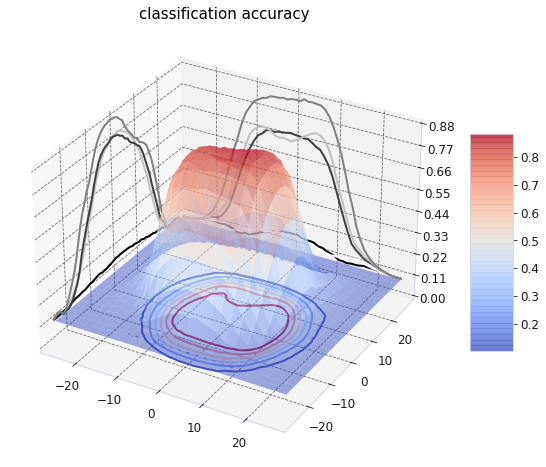

In [47]:
plt.style.use("gadfly")
fig = plt.figure(figsize=(10,8))

for i in range(55):
    for j in range(55):
        accuracy_map[i,j] = max(accuracy_map[i,j], 0.1) # taking out values that are less than 10%

ax = fig.add_subplot(111, projection='3d')

# Creating a meshgrid of coordinates
X = np.arange(-27, 28)
Y = np.arange(-27, 28)
X, Y = np.meshgrid(X, Y) 

surf = ax.plot_surface(X, Y, accuracy_map, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True, alpha=0.5)

#ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
cset = ax.contour(X, Y, accuracy_map, [0.2, 0.3, 0.4, 0.5, 0.6, 0.7], zdir='z', offset=0, cmap=cm.coolwarm, alpha = 1)
cset = ax.contour(X, Y, accuracy_map, [-20, -10, 0, 10, 20], zdir='x', offset=-27.5, cmap = 'gray')
cset = ax.contour(X, Y, accuracy_map,  [-20, -10, 0, 10, 20], zdir='y', offset=27.5, cmap = 'gray')


# Customize the z axis.
ax.set_xlim(-27.5, 27.5)
ax.set_zlim(-27.5, 27.5)
ax.set_zlim(0, 0.88)
ax.zaxis.set_major_locator(LinearLocator(9))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_title('classification accuracy', size=15)

# Add a color bar which maps values to colors.
cbar = fig.colorbar(surf, shrink=0.5, aspect=5, ticks=[0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9])
fig.savefig('../figures/stn_28x28_accuracy_map.png', bbox_inches='tight', pad_inches=0.1)